<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/assignment_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label Image Classification of Fruits on a Platter

My goal is to develop a deep learning model that can accurately identify and classify multiple fruits present in images of fruit platters.

The [dataset](https://universe.roboflow.com/suratthani-rajabhat-university/rcnn-oumhw) consists of images of fruit platters with various fruits arranged on them. Each image can contain one or more fruits from a set of 6 classes, including an "other" class for objects that are not among the defined fruit categories.

My approach applies theory I learned in the module "Computer Vision" by Susanne Suter and Marco Willi and tries to implement best practices according to [Karpathy:19](http://karpathy.github.io/2019/04/25/recipe/).

Google Colab GPUs: We start by using a A100 GPU

<br/>

<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/assignment_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base model from scratch

We start by creating a base model from scratch for predicting banana, no banana and a bounding box for the banana

### Loading the dataset

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pwd

/content


In [ ]:
%cd drive/MyDrive/assignment-computer-vision
# !ls -l

/content/drive/MyDrive/assignment-computer-vision


In [ ]:
%%capture

# %load_ext autoreload
# %autoreload 2
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.auto as tqdm

import tensorflow as tf

# from sklearn.model_selection import train_test_split

class print_style:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [ ]:
import plot_functions

In [ ]:
!nvidia-smi
tf.config.list_physical_devices('GPU')

Fri Nov 29 12:48:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Dataset configuration
base_path = 'data'
num_classes = 2
input_size = 244

recreate_dataset = False # we load from drive

In [ ]:
# Prepare for further processing
# Train
train_image_dir = os.path.join(base_path, 'train')
train_annotation_file = os.path.join(base_path, 'train/_annotations.csv')

if not os.path.exists(train_annotation_file):
    print(f"Error: Annotation file not found at {train_annotation_file}")

train_annotations = pd.read_csv(train_annotation_file)
train_image_files = glob.glob(os.path.join(train_image_dir, '*.jpg'))

# TEst
test_image_dir = os.path.join(base_path, 'test')
test_annotation_file = os.path.join(base_path, 'test/_annotations.csv')

if not os.path.exists(test_annotation_file):
    print(f"Error: Annotation file not found at {test_annotation_file}")

test_annotations = pd.read_csv(test_annotation_file)
test_image_files = glob.glob(os.path.join(test_image_dir, '*.jpg'))

# Validation
validation_image_dir = os.path.join(base_path, 'valid')
validation_annotation_file = os.path.join(base_path, 'valid/_annotations.csv')

if not os.path.exists(validation_annotation_file):
    print(f"Error: Annotation file not found at {validation_annotation_file}")

validation_annotations = pd.read_csv(validation_annotation_file)
validation_image_files = glob.glob(os.path.join(validation_image_dir, '*.jpg'))

We need a function to get all boxes for an image from the label file

In [ ]:
# Get all boxes for an image

def get_boxes_for_image(filename, annotations):
    """
    Gets all boxes for a specific image from the annotations DataFrame.

    Args:
        filename: The name of the image file.
        annotations: The pandas DataFrame containing the annotations.

    Returns:
        A dictionary where keys are box indices and values are dictionaries
        containing 'xmin', 'ymin', 'xmax', 'ymax', and 'class' for each box.
        Returns an empty dictionary if no boxes are found for the image.
    """
    image_annotations = annotations[annotations['filename'] == filename]
    boxes_dict = {}
    for index, row in image_annotations.iterrows():
        boxes_dict[index] = {
            'box': row[['xmin', 'ymin', 'xmax', 'ymax']].values,
            'label': row['class']
        }
    return boxes_dict

And we need a function to display our images with the corresponding boxes

In [ ]:
# A function for displaying an image with parameters image and boxes (each box has a label)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_boxes(plt_img, boxes):
    """Displays an image with bounding boxes and labels.

    Args:
        image_path: Path to the image file.
        boxes: A list of dictionaries, where each dictionary represents a box
               and contains 'xmin', 'ymin', 'xmax', 'ymax', and 'label' keys.
    """
    try:
        boxes = list(boxes.values())
        fig, ax = plt.subplots(1)
        ax.imshow(plt_img)

        for box in boxes:
            xmin = box['box'][0]
            ymin = box['box'][1]
            xmax = box['box'][2]
            ymax = box['box'][3]
            label = box['label']

            rect = patches.Rectangle((xmin, ymin),
                                     xmax - xmin,
                                     ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add the label to the box
            ax.text(xmin, ymin, label, color='r', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        plt.show()

    except KeyError as e:
        print(f"Error: Missing key in box dictionary: {e}")

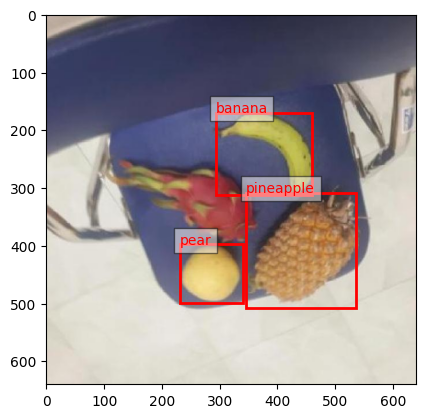

In [ ]:
# Show an image from train_annotations using display_image_with_boxes

# The first image file is at index 0
first_image_path = train_image_files[0]
first_filename = os.path.basename(first_image_path)
first_plt_img = plt.imread(first_image_path)
first_boxes = get_boxes_for_image(first_filename, train_annotations)
# print(first_boxes)

# Display the image with bounding boxes using the function
display_image_with_boxes(first_plt_img, first_boxes)

We want to resize to a smaller size to test our small base model - it's important to resize the boxes too for this to work

In [ ]:
import cv2 as cv
import numpy as np

def _resize_image_and_boxes(image, boxes, new_width, new_height):
    """Resizes the image and adjusts the bounding boxes accordingly."""
    # Get the original height and width using the 'shape' attribute
    original_height, original_width = image.shape[0], image.shape[1]

    # Resize using OpenCV
    resized_image = cv.resize(image, (new_width, new_height))

    # Adjust bounding boxes and maintain the original format
    resized_boxes = {}
    for box_index, box_data in boxes.items():
      # print(box_data['box'])
      xmin, ymin, xmax, ymax = box_data['box']
      xmin = int(xmin * new_width / original_width)
      ymin = int(ymin * new_height / original_height)
      xmax = int(xmax * new_width / original_width)
      ymax = int(ymax * new_height / original_height)

      # Ensure boxes stay within image bounds after resizing
      xmin = max(0, min(xmin, new_width - 1))
      ymin = max(0, min(ymin, new_height - 1))
      xmax = max(0, min(xmax, new_width - 1))
      ymax = max(0, min(ymax, new_height - 1))

      # Store the resized box in the same format as the input 'boxes'
      resized_boxes[box_index] = {
          'box': np.array([xmin, ymin, xmax, ymax]),
          'label': box_data['label']
      }

    return resized_image, resized_boxes

Let's resize and display our first image using _resize_image_and_boxes with some detail information

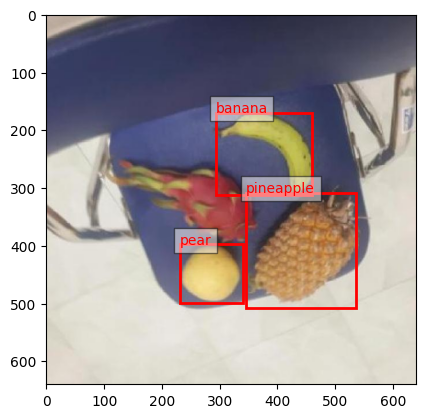

{5109: {'box': array([346, 308, 536, 508], dtype=object), 'label': 'pineapple'}, 5110: {'box': array([231, 397, 340, 498], dtype=object), 'label': 'pear'}, 5111: {'box': array([293, 169, 460, 312], dtype=object), 'label': 'banana'}}
{5109: {'box': array([131, 117, 204, 193]), 'label': 'pineapple'}, 5110: {'box': array([ 88, 151, 129, 189]), 'label': 'pear'}, 5111: {'box': array([111,  64, 175, 118]), 'label': 'banana'}}


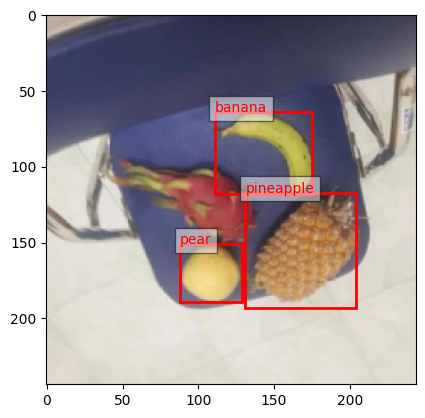

In [ ]:
# The first image file is at index 0
first_image_path = train_image_files[0]
first_filename = os.path.basename(first_image_path)
first_plt_img = plt.imread(first_image_path)
first_boxes = get_boxes_for_image(first_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(first_plt_img, first_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(first_plt_img, first_boxes, input_size, input_size)

# Print the resized boxes
print(first_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

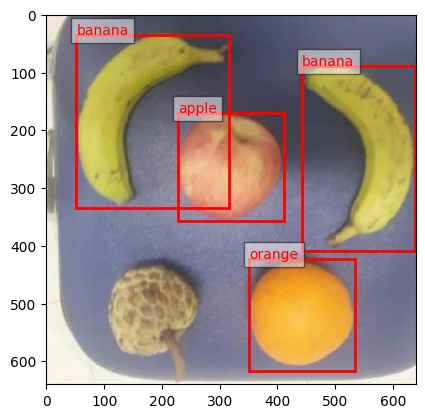

{2923: {'box': array([228, 169, 412, 356], dtype=object), 'label': 'apple'}, 2924: {'box': array([443, 88, 639, 409], dtype=object), 'label': 'banana'}, 2925: {'box': array([52, 34, 316, 335], dtype=object), 'label': 'banana'}, 2926: {'box': array([351, 422, 534, 616], dtype=object), 'label': 'orange'}}
{2923: {'box': array([ 86,  64, 157, 135]), 'label': 'apple'}, 2924: {'box': array([168,  33, 243, 155]), 'label': 'banana'}, 2925: {'box': array([ 19,  12, 120, 127]), 'label': 'banana'}, 2926: {'box': array([133, 160, 203, 234]), 'label': 'orange'}}


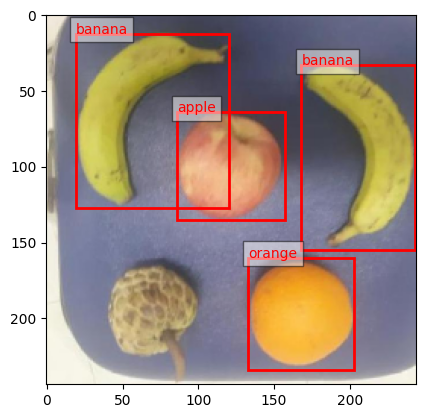

In [ ]:
# Another random example
x = random.randint(0, len(train_image_files))

# Image file is at index x
random_image_path = train_image_files[x]
random_filename = os.path.basename(random_image_path)
random_plt_img = plt.imread(random_image_path)
random_boxes = get_boxes_for_image(random_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(random_plt_img, random_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(random_plt_img, random_boxes, input_size, input_size)

# Print the resized boxes
print(random_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

This seems to work, great! Let's make sure we have tensorflow installed

In [ ]:
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

import tensorflow as tf
print(tf.__version__)

2.17.1


## Data preparation

This is where the magic happens - we prepare the data for our model specifically for our model. We resize each image with boxes and prepare the tensors for further use.

In [ ]:
# Test function: Check for filenames without a label banana

# # Iterate through the annotations and find filenames without 'banana' label
# filenames_without_banana = []
# for filename in set(train_annotations['filename']):
#     boxes = get_boxes_for_image(filename, train_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana.append(filename)
#     else:
#       filenames_without_banana.append(filename)

# print(f"Filenames without 'banana' label in training set: {filenames_without_banana}")

# #Repeat for test and validation sets
# filenames_without_banana_test = []
# for filename in set(test_annotations['filename']):
#     boxes = get_boxes_for_image(filename, test_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_test.append(filename)
#     else:
#       filenames_without_banana_test.append(filename)

# print(f"Filenames without 'banana' label in test set: {filenames_without_banana_test}")

# filenames_without_banana_validation = []
# for filename in set(validation_annotations['filename']):
#     boxes = get_boxes_for_image(filename, validation_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_validation.append(filename)
#     else:
#       filenames_without_banana_validation.append(filename)

# print(f"Filenames without 'banana' label in validation set: {filenames_without_banana_validation}")

### Preparation for our model

We iterate and prepare each image. We resize and append one banana box or a dummy box for pictures without a banana to correspond with our model.

As pointed out by the many debug print statements, this part was tricky!

In [ ]:
def data_load(image_files, annotations):
    X = []
    Y = []

    for image_file in image_files:
        img = cv.imread(os.path.join(image_file), cv.IMREAD_GRAYSCALE)
        boxes = get_boxes_for_image(os.path.basename(image_file), annotations)

        # resize everything
        img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)

        # Check if a banana box exists
        banana_box_found = False
        for box_data in boxes.values():
            if box_data['label'] == 'banana':
                banana_box_found = True
                label = 1
                box = np.array(box_data['box'], dtype=float)
                break  # Stop searching after finding the first banana box

        # Handle images with no banana box
        if not banana_box_found:
            label = 0  # Set label to 0 for "no banana"
            box = np.array([0, 0, 0, 0], dtype=float)  # Create a dummy bounding box

        # resize_img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)
        # print(boxes)
        # return
        img = img.astype(float) / 255.
        # print(img)
        # print(box)
        # we already have a float array
        box = np.asarray(box, dtype=float)
        # we wait with normalizing the bounding boxes
        # box = box / input_size
        # print(box)
        # box = np.append(box, label)
        label = np.append(box, label)
        # print(label)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    # we expand for the batch dimension
    X = np.expand_dims(X, axis=3)
    Y = np.array(Y)
    # print(X)
    # print(Y)

    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

Because this part can take a lot of time, depending on the connection from colab to Google Drive, we can recreate or reload here.

In [ ]:
if recreate_dataset:
  print('recreating ds')
  raw_train_ds = data_load(train_image_files, train_annotations)
  raw_validation_ds = data_load(validation_image_files, validation_annotations)
  raw_test_ds = data_load(test_image_files, test_annotations)
else:
  # load from drive
  print('loading from drive')
  raw_train_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_one_banana_only_saved')
  raw_validation_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_one_banana_only_saved')
  raw_test_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_one_banana_only_saved')

  # raw_train_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
  # raw_validation_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
  # raw_test_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

loading from drive


In [ ]:
!pwd

/content/drive/MyDrive/assignment-computer-vision


In [ ]:
# tf.data.Dataset.save(raw_train_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
# tf.data.Dataset.save(raw_validation_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
# tf.data.Dataset.save(raw_test_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

# tf.data.Dataset.save(raw_train_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved_long_run')
# tf.data.Dataset.save(raw_validation_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved_long_run')
# tf.data.Dataset.save(raw_test_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved_long_run')

We need to hot encode the labels. We could also use the label directly, since we have a binary classification.

In [ ]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

We define the batch size and tune the datasets for our pipeline

In [ ]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_ds = tune_training_ds(raw_train_ds)

In [ ]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_image_files) // 4)
    # dataset = dataset.repeat()
    return dataset

In [ ]:
validation_ds = tune_validation_ds(raw_validation_ds)

In [ ]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(test_image_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [ ]:
test_ds = tune_test_ds(raw_test_ds)

### Dataset ispection

Ensure we have the dataset correct: Inspect the first image from the training_ds with boxes

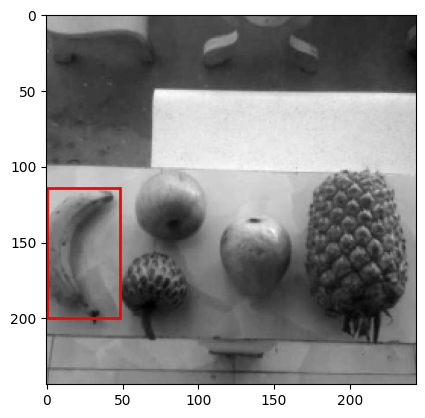

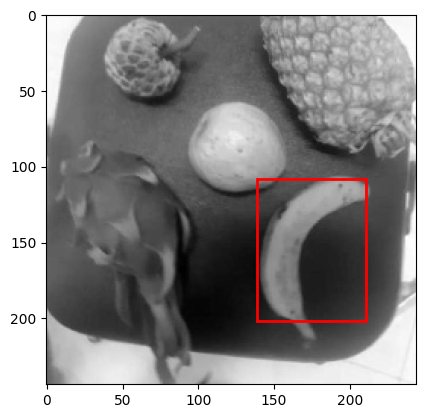

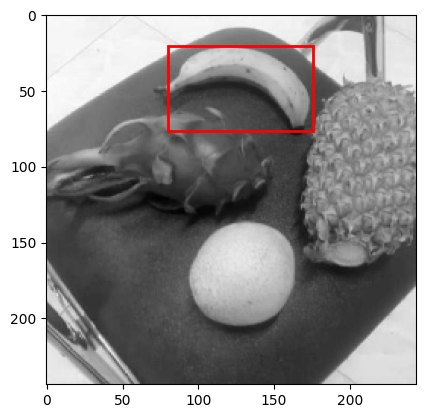

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for image, (label, box) in train_ds.take(3):
    # Convert the image to a NumPy array and remove the batch dimension
    image = image.numpy()[0, :, :]  # Assuming grayscale image and removing channel dim

    # print(label, box)

    # Accessing the bounding box coordinates and label
    xmin = box[0][0].numpy()
    ymin = box[0][1].numpy()
    xmax = box[0][2].numpy()
    ymax = box[0][3].numpy()
    # print(xmin, ymin, xmax, ymax)
    label = label[0].numpy()
    # print(label)


    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')  # Display grayscale image

    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display the plot
    plt.show()

## Building the model

We are building a simple object detector, our model has two heads: one to classify the object type (or label or class) and another head to output the object bounding box.

Addendum: I think this is where we take a wrong turn. I don't think it's possible to train this model for our purpose. More on this below.
We tried improving by introducing optimized Learning Rate (ReduceLROnPlateau), Dropout and L2 Regularization, Different optimizers Adam <-> SGD, but without much improvement.

In [ ]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01), # L2 regularization
                              input_shape=(input_size, input_size, 1))(inputs)

    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # L2 regularization
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # L2 regularization
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu'
  , kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='sigmoid', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units=4, name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    #           loss = {'classifier_head' : 'binary_crossentropy', 'regressor_head' : 'mse' },
    #           metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    model.compile(optimizer=tf.keras.optimizers.Adam(),
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = {'classifier_head' : 'binary_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [ ]:
model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 244, 244, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 242, 242, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 242, 242, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 121, 121, 16)   │              0 │ dropout[0][0]          │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 119, 119, 32)   │          4,640 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 119, 119, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 59, 59, 32)     │              0 │ dropout_1[0][0]        │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 57, 57, 64)     │         18,496 │ average_pooling2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 57, 57, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 28, 28, 64)     │              0 │ dropout_2[0][0]        │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50176)          │              0 │ average_pooling2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │      3,211,328 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier_head (Dense)   │ (None, 2)              │            130 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regressor_head (Dense)    │ (None, 4)              │            260 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

We keep the model small for now:

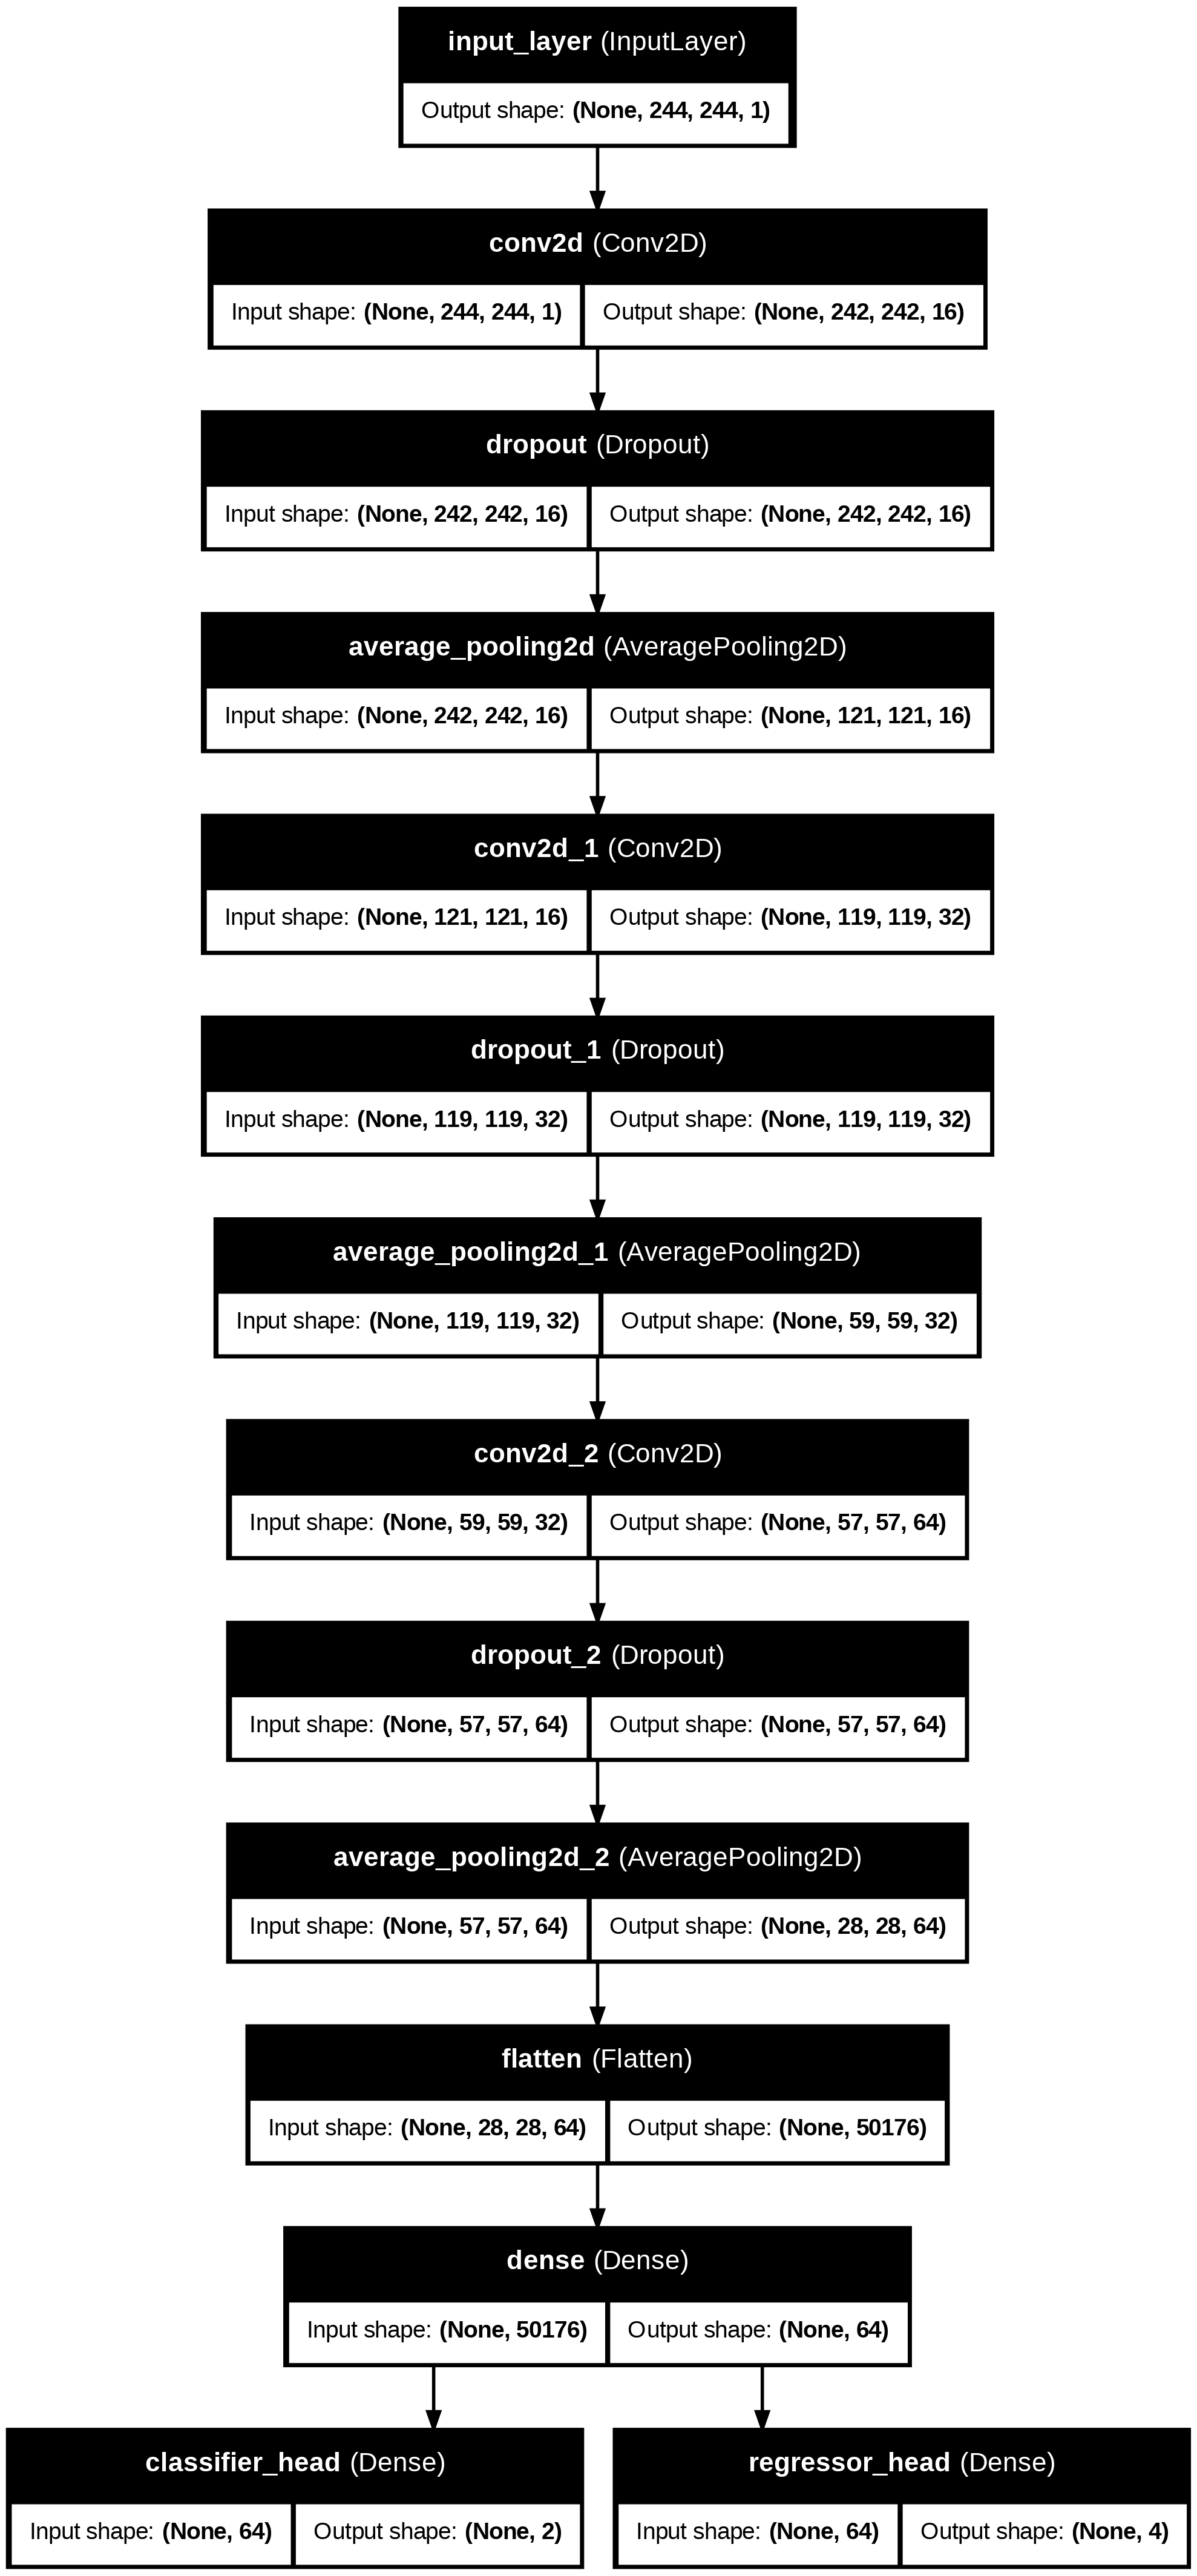

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

### Training

We train for 1000 epochs with early stopping for Validation Loss and a lot of patience.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 1000

model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True) # Add EarlyStopping callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(train_ds,
                    steps_per_epoch=(len(train_image_files) // BATCH_SIZE),
                    validation_data=validation_ds,
                    epochs=EPOCHS,
                    callbacks=([early_stopping], [reduce_lr]) # Pass callbacks to model.fit
                    )

Epoch 1/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - classifier_head_accuracy: 0.7382 - classifier_head_loss: 3.8264 - loss: 7253.6309 - regressor_head_loss: 7247.3057 - regressor_head_mse: 7247.3057 - val_classifier_head_accuracy: 0.3983 - val_classifier_head_loss: 1.8420 - val_loss: 5655.4331 - val_regressor_head_loss: 5639.9028 - val_regressor_head_mse: 5650.8535 - learning_rate: 0.0010
Epoch 2/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - classifier_head_accuracy: 0.7502 - classifier_head_loss: 0.8548 - loss: 4421.1162 - regressor_head_loss: 4417.4814 - regressor_head_mse: 4417.4814 - val_classifier_head_accuracy: 0.3983 - val_classifier_head_loss: 1.3022 - val_loss: 4890.3711 - val_regressor_head_loss: 4895.7217 - val_regressor_head_mse: 4886.3213 - learning_rate: 0.0010
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - classifier_head_accuracy: 0.7462 - classifier_head_loss: 0.7647 - loss: 4210.5298 - regressor_head_loss: 4206.9351 - regressor_head_mse: 4206.9351 - val_c

## Evaluation

Let's evaluate the last training run

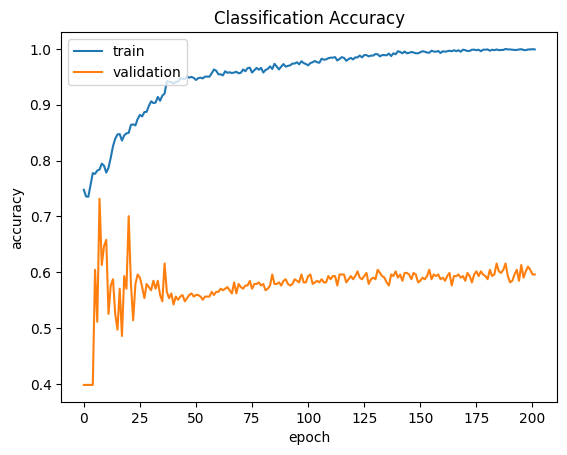

In [ ]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

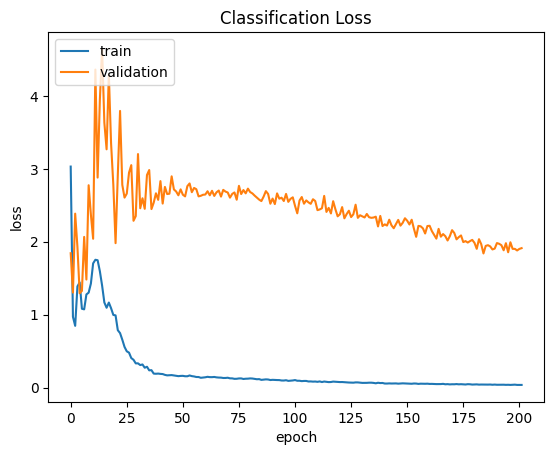

In [ ]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

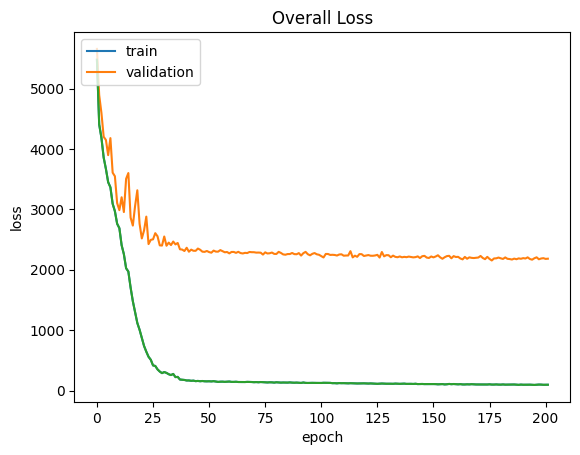

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Overall Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

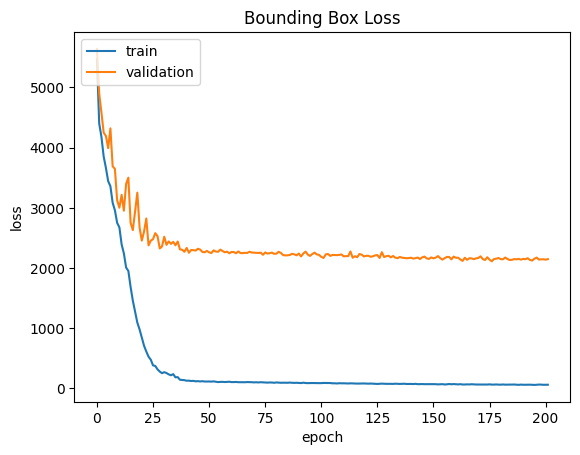

In [ ]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

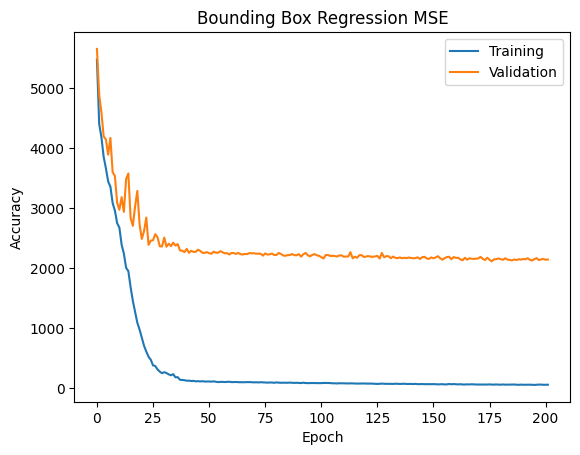

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['regressor_head_mse'])
plt.plot(history.history['val_regressor_head_mse'])
plt.title('Bounding Box Regression MSE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Analysis: I believe that the classification head overfits right away and prevents the regressor head to train after that.

One way to solve this would be to freeze the classification head only train the regressor head from this point on. Unfortunately time was running out on this assignment and I coud not implement this strategy. I am looking forward to try this out next year since it's a very interesting challenge.

## Predictions

We predict a few examples using IoU

In [ ]:
# IoU evaluation

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1: A NumPy array representing the first bounding box [xmin, ymin, xmax, ymax].
        box2: A NumPy array representing the second bounding box [xmin, ymin, xmax, ymax].

    Returns:
        The IoU value (a float between 0 and 1).
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
(244, 244, 1)
Image 0: True Label: 1 Pred Label: 1, True box [117. 141. 173. 181.] Pred box [38.717358 48.57142  56.61641  79.15069 ]
Image 0: IoU: 0.0


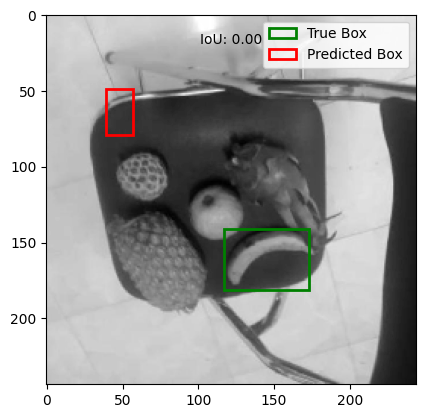

(244, 244, 1)
Image 1: True Label: 1 Pred Label: 1, True box [ 83.  35. 167.  81.] Pred box [ 87.886215  61.627785 186.34724  153.64636 ]
Image 1: IoU: 0.13453813122190642


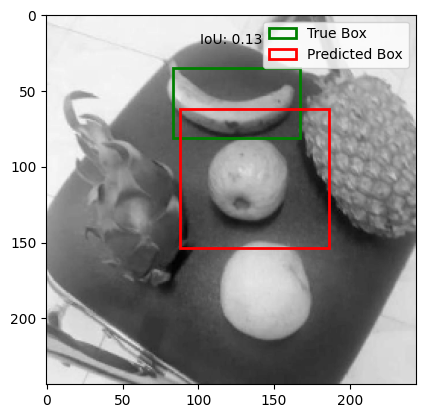

(244, 244, 1)
Image 2: True Label: 1 Pred Label: 1, True box [ 38. 141.  91. 222.] Pred box [ 63.43857 137.50578 112.50549 222.23273]
Image 2: IoU: 0.3590451139598958


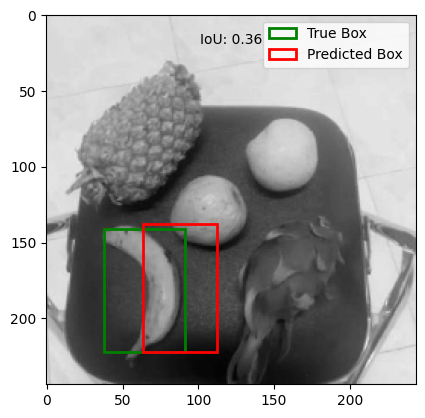

(244, 244, 1)
Image 3: True Label: 1 Pred Label: 1, True box [ 73.  91. 117. 138.] Pred box [42.770073 43.02264  68.40738  80.73093 ]
Image 3: IoU: 0.0


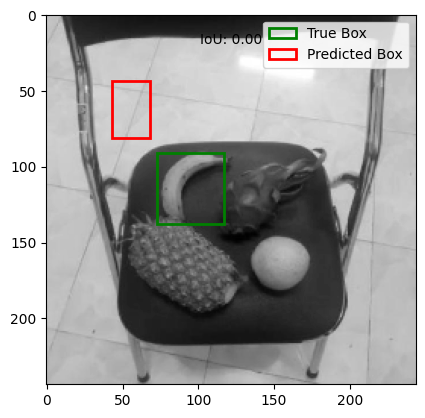

(244, 244, 1)
Image 4: True Label: 1 Pred Label: 1, True box [112.  44. 205.  94.] Pred box [ 41.185852  29.259169 101.64651   70.52539 ]
Image 4: IoU: 0.0


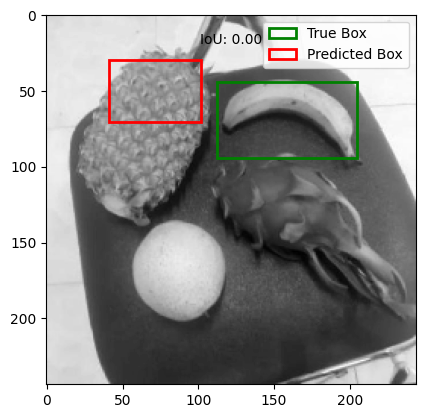

(244, 244, 1)
Image 5: True Label: 0 Pred Label: 0, True box [0. 0. 0. 0.] Pred box [16.633781 11.757379 16.858515 20.360073]
Image 5: IoU: 0.0


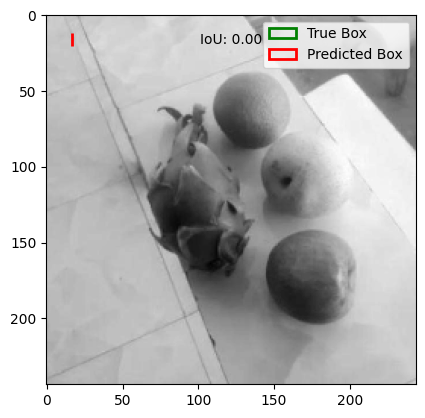

(244, 244, 1)
Image 6: True Label: 1 Pred Label: 1, True box [ 27. 136.  80. 221.] Pred box [ 54.0497  143.24585 107.50718 252.85017]
Image 6: IoU: 0.2417493414449623


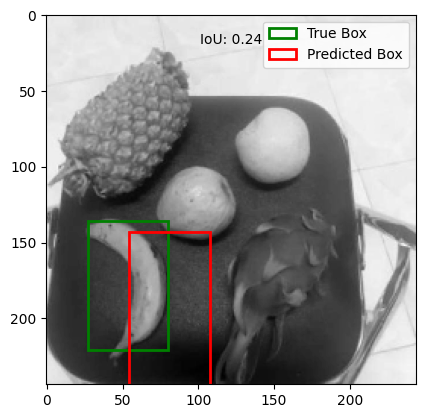

(244, 244, 1)
Image 7: True Label: 0 Pred Label: 1, True box [0. 0. 0. 0.] Pred box [ 70.43235  58.31068 102.00955 122.58383]
Image 7: IoU: 0.0


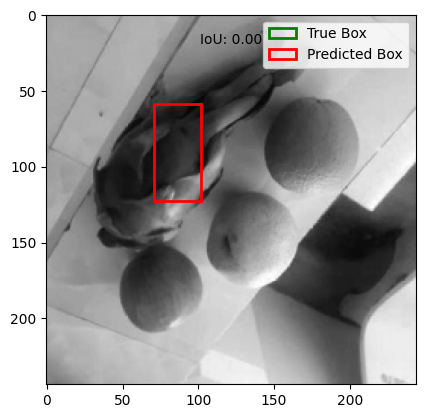

(244, 244, 1)
Image 8: True Label: 1 Pred Label: 1, True box [  8.  67.  55. 139.] Pred box [ 31.340044  64.05937   85.21943  139.40134 ]
Image 8: IoU: 0.2967870578205222


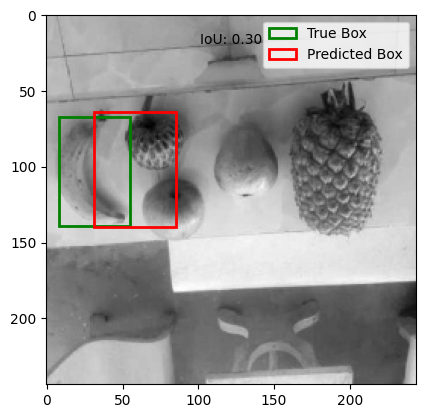

(244, 244, 1)
Image 9: True Label: 1 Pred Label: 1, True box [120.  22. 198. 100.] Pred box [ 94.14583    -2.3705282 173.31004    61.580658 ]
Image 9: IoU: 0.23350009407274694


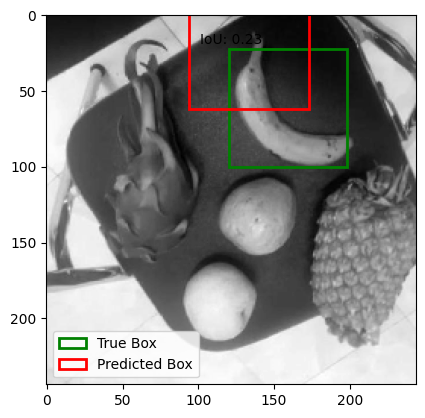

In [ ]:
# Predict some examples from the test set

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

for image, (label, box) in test_ds.take(1):  # Get the first batch
    # print(len(image))
    # Get predictions
    predictions = model.predict(image)

    # Assuming 'predictions' is a tuple with classification and bounding box
    predicted_labels = predictions[0]
    predicted_boxes = predictions[1]


    for i in range(10): # predict 10 images from the batch
        # Convert image to NumPy array
        print(image[i].numpy().shape)
        img = image[i].numpy()[:, :, 0]

        # Get true values
        true_label = label[i].numpy().argmax()
        true_box = box[i].numpy()

        # Get predicted values
        pred_label = predicted_labels[i].argmax()
        pred_box = predicted_boxes[i]
        print(f"Image {i}: True Label: {true_label} Pred Label: {pred_label}, True box {true_box} Pred box {pred_box}")

        # Create plot
        fig, ax = plt.subplots(1)
        ax.imshow(img, cmap='gray')

        # Add true bounding box
        rect_true = patches.Rectangle((true_box[0], true_box[1]), (true_box[2]-true_box[0]), (true_box[3]-true_box[1]), linewidth=2, edgecolor='g', facecolor='none', label='True Box')
        ax.add_patch(rect_true)

        # Add predicted bounding box
        rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), (pred_box[2]-pred_box[0]), (pred_box[3]-pred_box[1]), linewidth=2, edgecolor='r', facecolor='none', label='Predicted Box')
        ax.add_patch(rect_pred)

        ax.legend()

        # Calculate IoU
        iou = calculate_iou(true_box, pred_box)
        print(f"Image {i}: IoU: {iou}")

        # Add IoU to the plot (optional)
        plt.text(0.5, 0.95, f"IoU: {iou:.2f}", ha='center', va='top', transform=ax.transAxes)  # Position the text

        # Display the plot
        plt.show()

## Conclusion

This model cannot solve our problem, but gave us countless insights into resizing boxes, displaying our images with correspoinding boxes (before and after resizing), bringing them into the right format for further consumption by our model and different strategies for optimizing the model. Unfortunately to no avail with this architecture.

My takeaway is, that an approach from scratch takes more time than expected but gives a lot of insight about what happens under the hood of established frameworks. If I would have had more time, I would start by redefining the architecture of the model and finding a better solution in this regard.

We will now move on to such an established and more suitable model, YOLOv5.